In [8]:
import numpy as np

In [9]:
# load data
train_file = "C:/IITD/sem5/col774-ml/datasets/decision_tree/decision_tree/train.csv"
test_file = "C:/IITD/sem5/col774-ml/datasets/decision_tree/decision_tree/test.csv"
val_file = "C:/IITD/sem5/col774-ml/datasets/decision_tree/decision_tree/val.csv"
train_data = np.genfromtxt(train_file, delimiter=',')
test_data = np.genfromtxt(test_file, delimiter=',')
val_data = np.genfromtxt(val_file, delimiter=',')

In [10]:
def extract_data(data):
    x = data[:, :-1]
    y = data[:, -1].astype('int')
    return x, y

In [11]:
train_data = train_data[2: :]
x, y = extract_data(train_data)
num_attributes = x.shape[1]
num_labels = 7

In [12]:
def entropy(y):
    counts = np.bincount(y, minlength=num_labels+1) # count occurences of each label
    prob = counts / y.size # probability for each label
    # print("entr", counts, prob)
    summation = 0
    for k in range(1, num_labels + 1):
        if prob[k] != 0:
            summation += prob[k] * np.log2(prob[k])
    return -summation
    # return -sum(prob[k] * np.log2(prob[k]) for k in range(1, num_labels + 1))

In [13]:
def choose_best_attribute(D):
    x, y = extract_data(D)
    max_MI = -1
    max_j = -1
    for j in range(num_attributes):
        if j > 10:
            # discrete attribute
            D0 = D[x[:, j] == 0]
            D1 = D[x[:, j] == 1]
        else:
            # continuous attribute 
            median = np.median(x[:, j])
            D0 = D[x[:, j] <= median]
            D1 = D[x[:, j] > median]
        x0, y0 = extract_data(D0)
        x1, y1 = extract_data(D1)
        p0 = y0.size / y.size
        p1 = y1.size / y.size
        MI = entropy(y) - (entropy(y0) * p0 + entropy(y1) * p1) # mutual information
        # print("MI", MI, j, entropy(y), entropy(y0), entropy(y1))
        if MI > max_MI:
            max_MI = MI
            max_j = j
    return max_j

In [22]:
class Node:
    def __init__(self, attribute, majority_class):
        self.attribute = attribute
        self.majority_class = majority_class
        self.children = None

    def create_leaf(class_label):
        leaf = Node(attribute=None, majority_class=class_label)
        return leaf

    def is_leaf(self):
        return self.children == None

    def add_child(self, node):
        if self.children == None:
            self.children = [node]
        else:
            self.children.append(node)

    def set_attribute(self, attribute):
        self.attribute = attribute

    def set_attribute_median(self, attribute_median):
        self.attribute_median = attribute_median

In [120]:
class DecisionTree:

    def __init__(self, train_data, max_depth=99999999):
        self.train_data = train_data
        self.max_depth = max_depth
        self.num_nodes = 0
        self.depth = 0

    def grow_tree(self, D, max_depth):
        # if self.num_nodes % 5000 == 0:
        #     print("gt", D.shape, max_depth, self.depth, self.num_nodes)
        x, y = extract_data(D)
        if np.all(y == y[0]):
            # leaf node
            self.num_nodes += 1
            return Node.create_leaf(y[0])
        else:
            majority_class = np.argmax(np.bincount(y)[1:])
            j = choose_best_attribute(D)
            node = Node(j, majority_class)
            self.num_nodes += 1
            if j > 10:
                # discrete attribute
                D0 = D[x[:, j] == 0]
                D1 = D[x[:, j] == 1]
            else:
                # continuous attribute 
                attribute_median = np.median(x[:, j])
                D0 = D[x[:, j] <= attribute_median]
                D1 = D[x[:, j] > attribute_median]
                node.set_attribute_median(attribute_median)

            max_depth -= 1
            self.depth = max(self.depth, self.max_depth - max_depth)
            if max_depth == 0:
                return node
            node.add_child(self.grow_tree(D0, max_depth))
            node.add_child(self.grow_tree(D1, max_depth))
            return node

    def train(self):
        self.root = self.grow_tree(self.train_data, self.max_depth)

    def predict(self, x):
        return self.predict_node(self.root, x)

    def predict_node(self, node, x):
        if node.is_leaf():
            return node.majority_class
        else:
            j = node.attribute
            if j > 10:
                # discrete attribute
                return self.predict_node(node.children[int(x[j])], x)
            else:
                # continuous attibute
                if x[j] <= node.attribute_median:
                    child = node.children[0]
                else:
                    child = node.children[1]

                if not child:
                    return node.majority_class
                else:
                    return self.predict_node(child, x)



In [111]:
x_train, y_train = extract_data(train_data[2:])
x_test, y_test = extract_data(test_data[2:])
x_val, y_val = extract_data(val_data[2:])

In [125]:
acc_list = []

for max_depth in range(1, 25):
    print("DT", max_depth)

    dtree = DecisionTree(train_data, max_depth=max_depth)
    dtree.train()

    train_acc = sum(int(dtree.predict(x_train[i]) == y_train[i]) for i in range(y_train.size)) * 100 / y_train.size
    test_acc = sum(int(dtree.predict(x_test[i]) == y_test[i]) for i in range(y_test.size)) * 100 / y_test.size
    val_acc = sum(int(dtree.predict(x_val[i]) == y_val[i]) for i in range(y_val.size)) * 100 / y_val.size

    print(dtree.depth, dtree.num_nodes, train_acc, test_acc, val_acc)
    acc_list.append((dtree.depth, dtree.num_nodes, train_acc, test_acc, val_acc))

DT 1
1 1 36.45046311788707 36.61455284272874 36.3562526055518
DT 2
2 3 6.8885907523785255 6.876097661765212 6.957003004470767
DT 3
3 7 7.415412293116629 7.3952271083715 7.465175452467547
DT 4
4 15 12.631129749759769 12.632149867419677 12.646809367048574
DT 5
5 31 9.848738360651712 9.78597747856331 9.857251699897935
DT 6
6 63 10.455074341396323 10.473845518096352 10.46605235541883
DT 7
7 127 11.131714595351323 11.145356245049761 11.097134971177207
DT 8
8 253 11.472183761247916 11.495747098729295 11.441427195491856
DT 9
9 497 10.789096390535633 10.82079272702228 10.864971320960855
DT 10
10 947 12.116588431416494 12.228382520059231 12.142949556517115
DT 11
11 1761 14.495881520414335 14.61827197906264 14.575277086957147
DT 12
12 3173 18.892201137762605 19.00719721753504 19.064013915443553
DT 13
13 5497 23.979283264819927 24.156307035366233 24.002702586144935
DT 14
14 9087 30.10557921203953 29.73673335858673 29.81038770610813
DT 15
15 14267 37.79545447568056 36.927924515307 37.0929948392105

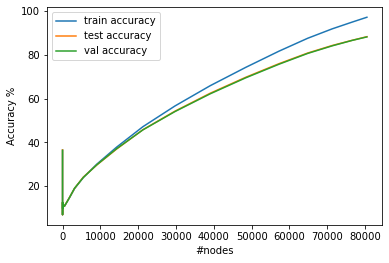

In [139]:
import matplotlib.pyplot as plt

nodes = [acc[1] for acc in acc_list]
test_acc = [acc[3] for acc in acc_list]
train_acc = [acc[2] for acc in acc_list]
val_acc = [acc[4] for acc in acc_list]


plt.plot(nodes, train_acc, label="train accuracy")
plt.plot(nodes, test_acc, label="test accuracy")
plt.plot(nodes, val_acc, label="val accuracy")
plt.legend()
plt.xlabel("#nodes")
plt.ylabel("Accuracy %")
plt.savefig("q1_a.png")